## base accuracy = 0.48789
## improved accuracy = 0.56824

improvements to make
- `word = word.strip().lower()` in `get_features_text()` function
    - resulted in marginal increase: 0.49526
    - This strips the word to ensure there is no whitespace and lowers case to better match with doc
- `features.append(label_count / len(words) if len(words) > 0 else 0)` 
    - This normalises the label count by the length of the text, to stop longer texts being seen as more important solely based on their length
    - 0.49842
- `for char in ',.!?;:-':
    text = text.replace(char, ' ')`
    - largest improvement in accuracy 0.54631
- `avg_word_len = sum(len(w) for w in words) / len(words) if words else 0 features.append(avg_word_len)`
    - this worsened accuracy so removed
- `dollar_count = text.count('#36;') + text.count('$')`
    - improved accuracy to 0.56824
    - not just dollar because I noticed the #36; often in front of billiions etc in the text
- main learning point you can have as many features as you want, and when you multiply features (X - (samples, features)) by the weights (features, classes), it will create a vector as long as the number of classes (Z - (samples, classes)).

# Original Implementation

### Library Imports

In [40]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
seed = 42

### Functions used

In [ ]:
def get_features_text(text: str):
  """
    Calculated text features for the given text.
    Args:
        text (string): string containing the text.
    Returns:
        List with dimension 4: list containing the features extracted from the text in the order [ln text_len, # sports words, # business words, # science words].
    """
  for char in ",.!?;:-'\'":
    text = text.replace(char, ' ')
  words = text.split()
  words = [word.strip().lower() for word in words]
  features = [math.log(len(words))]

  dollar_count = text.count('#36;') + text.count('$')
  features.append(dollar_count)

  percent_count = text.count('%') + text.lower().count('percent')
  features.append(percent_count)

  # labels = ['sports', 'business', 'science']
  for label in labels:
    with open(f'{label}.txt', 'r') as label_file:
      # label_words - in file each word is on a new line
      label_words = label_file.read().split('\n')
    label_count = 0

    # for each word in the text,
    for word in words:
      if word in label_words:
        label_count += 1
    # normlasing for length of text
    features.append(label_count / len(words) if len(words) > 0 else 0)

  # return [ln text_len, # sports words, # business words, # science words]
  return features


def standardise_features(X: np.ndarray):
    """
      Standardise the features contained in the given dataset.
      Args:
          X (array): array with dimension (num_samples, num_features).
      Returns:
          array with dimension (num_samples, num_features): dataset with standardised features.
    """
    # Check means and standard deviations for each features
    means = X.mean(axis=0)
    stds = X.std(axis=0)

    print("Means of features:", means)
    print("Standard deviations of features:", stds)

    # If not standardised, apply Standard Scaling (Z-score standardisation)
    if any(stds != 1) or any(means != 0):
        scaler = StandardScaler()
        standardised_X = scaler.fit_transform(X)
        after_means = X.mean(axis=0)
        after_stds = X.std(axis=0)
        print("\nMeans of features after standardisation:", after_means)
        print("Standard deviations of features after standardisation:", after_stds)
    else:
        print("Dataset is already standardised.")
    return standardised_X

def softmax(Z: np.ndarray):
  """
    Softmax function that gives us the predictions of the given samples using our model.
    Args:
        Z (array): array with dimension (num_train_samples, num_class), each row contains z = b + w_1 x_1 + w_2 x_2 + ... + w_n x_n
    Returns:
        array with dimension (num_train_samples, num_class): array containing a prediction made by the model for each sample.
  """
  exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
  return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

def prepocess_data(filename):
  """
    Preprocess the given dataset to set it in the correct format, i.e.
    containing 2 columns (label, text_features) with standardised text features and adding bias to the features.
    This function collects all the steps described in details in Sections 2.1 and 2.2

    Args:
        filename (string): name of the file containing the dataset.

    Returns:
        X: bias+features extracted from the samples in the dataset.
        y: gold labels of the dataset.
  """
  df = pd.read_csv(filename, header=None)
  df = df[df[0] != 1]
  df['label'] = df[0]-2
  df['text'] = [" ".join((title, body)) for title, body in zip(df[1], df[2])]
  df = df.drop(columns=[0,1,2])

  df['text_features'] = [get_features_text(text) for text in df['text']]

  X = np.array(df['text_features'].to_list())
  X_standardised = standardise_features(X) #standardise test set
  X = np.c_[np.ones(X_standardised.shape[0]), X_standardised]

  y = df['label'].to_list()

  return X, y

### Required files

In [42]:
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1QfAUt0u4wLZVy2Ta1G90jOLNaqzAw2eW' -O agnews_test.csv
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1UsOBTnfch-Su4kqmkzXcIizwJt6NWtXZ' -O agnews_train.csv
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1XWzN3nBPcWp50f_DjC2rpS7G2PvzjvmB' -O business.txt
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1u3KQGgkFTN8s4fTGzJJOsmR4MGVlusp1' -O science.txt
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1g_gYaij_xn1HwGebruK3JJRZy30P7E49' -O sports.txt
# clear_output()

### Implementation

In [43]:
labels = ['sports', 'business', 'science']

df = pd.read_csv('agnews_train.csv', header=None)
df = df[df[0] != 1] # discard label 1 (World)

df['label'] = df[0]-2 # left with 2,3,4 so minus 2 = 1,2,3 which we want as our labels

df['text'] = [" ".join((title, body)) for title, body in zip(df[1], df[2])] # join text and title

processed_df = df.drop(columns=[0,1,2]) # just need to keep label and text

# using function defined above to get features from our text
processed_df['text_features'] = [get_features_text(text) for text in processed_df['text']]

# processed_df.head(10)

X = np.array(processed_df['text_features'].to_list()) # features
y_train = processed_df['label'].to_list() # target

# Check dataset shapes
print(f"Dataset inputs or features shape (num_samples, num_features): {X.shape}") # -> (90000, 4)
# assert X.shape == (90000, 5)
print(f"Dataset outputs or labels shape (num_samples, ): {len(y_train)}") # -> 90000
# assert len(y_train) == 90000

X_standardised = standardise_features(X) #standardise train set

X_train = np.c_[np.ones(X_standardised.shape[0]), X_standardised] # not using X_standardised

# Check training sets shapes
print(f"Training set shape (num_samples x (num_features+bias)): {X_train.shape}") # -> (90000, 5)
# assert X_train.shape == (90000, 6)

# Initialize weights
num_classes = len(np.unique(y_train))
weights = np.zeros((X_train.shape[1], num_classes))

# Check weights shape
print(f"Weights Shape (num_features+bias, num_classes): {weights.shape}") # -> (5, 3)
# assert weights.shape == (6, 3)

# Learning rate and number of iterations
learning_rate = 0.001
num_iterations = 5000

Dataset inputs or features shape (num_samples, num_features): (90000, 6)
Dataset outputs or labels shape (num_samples, ): 90000
Means of features: [3.63249865 0.11624444 0.04786667 0.02193035 0.04269181 0.00490983]
Standard deviations of features: [0.26221018 0.42126596 0.25367938 0.03145212 0.04401812 0.01398497]

Means of features after standardisation: [3.63249865 0.11624444 0.04786667 0.02193035 0.04269181 0.00490983]
Standard deviations of features after standardisation: [0.26221018 0.42126596 0.25367938 0.03145212 0.04401812 0.01398497]
Training set shape (num_samples x (num_features+bias)): (90000, 7)
Weights Shape (num_features+bias, num_classes): (7, 3)


Training:   0%|          | 15/5000 [00:00<00:34, 142.80it/s]

Z Shape (num_train_samples, num_class): (90000, 3)
Predictions Shape (num_train_samples, num_class): (90000, 3)
Error Shape (num_train_samples, ): (90000, 3)
Gradient Shape (num_features+bias, num_class): (7, 3)
Weights Shape (num_features+bias, num_class): (7, 3)


Training: 100%|██████████| 5000/5000 [00:33<00:00, 147.19it/s]


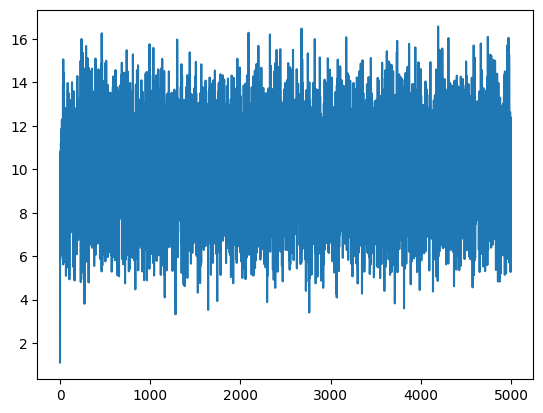

In [44]:
# Training the model
losses = []
for i in tqdm(range(num_iterations), total=num_iterations, desc="Training"):


  # 1. Calculate Z
  # X_train: (num_train_samples, num_features+bias) x weights: (num_features+bias, num_class) -> Z: (num_train_samples, num_class)
  # X_train is all of the features and because u dot product with weights then it still matches the number of classes
  Z = np.dot(X_train, weights)
  if i==0:
    print('Z Shape (num_train_samples, num_class):', Z.shape) # -> (90000, 3)
    assert Z.shape == (90000, 3)

  # 2. Get predictions
  # Z: (num_train_samples, num_class) -> predictions: (num_train_samples, num_class)
  predictions = softmax(Z)
  if i==0:
    print('Predictions Shape (num_train_samples, num_class):', predictions.shape) # -> (90000, 3)
    assert predictions.shape == (90000, 3)

  # 3. Compute error between prediction and real label
  '''
  The prediction for each data item is a vector of probabilites summing to 1.
  For example, if we have a prediction for a data point like this: [0.2, 0.5, 0.3],
  we can read this as there is 0.2 probability that the data item belongs to the first class,
  0.5 to the second class, and 0.3 to the third class. Our gold label is just the index
  of the class, taking the values 0, 1 or 2. Let's assume our gold label is 2.
  To compare our predictions to the label, we need to represent the label in a comparable format.
  To achieve this, we can use one-hot encoding for the labels (setting 1 in the desired index and 0 elsewhere),
  giving the following for a label of 2: [0, 0, 1].
  This we can compare to the prediction, finding that we are off by 0.7 from the perfect true class probability (1).

  Hint: to get the one-hot encoding of the labels (y_train in our case), think about using np.eye() function
  '''
  # predictions: (num_train_samples, num_class) y_train: (num_train_samples, ) -> errors: (num_train_samples, num_class)
  y_train_one_hot = np.eye(num_classes)[y_train]
  errors = predictions - y_train_one_hot
  if i==0:
    print('Error Shape (num_train_samples, ):', errors.shape)  # -> (90000, 3)
    assert errors.shape == (90000, 3)

  # 4. Calculate gradient
  #  We transpose X_train to align the dimensions correctly with the error dimension for matrix multiplication.
  # X_train.T: (num_features+bias, num_train_samples) x error: (num_train_samples, num_class) -> gradient or change in weights vector: (num_features+bias, num_class)
  gradients = np.dot(X_train.T, errors)
  if i==0:
    print('Gradient Shape (num_features+bias, num_class):', gradients.shape)  # -> (5, 3)
    # assert gradients.shape == (6, 3)

  # 5. Update weights
  # gradient: (num_features+bias, num_class) -> weights: (num_features+bias, num_class)
  weights -= learning_rate * gradients
  if i==0:
    print('Weights Shape (num_features+bias, num_class):', weights.shape) # -> (5, 3)
    # assert weights.shape == (6, 3)
  ## END OF YOUR CODE ##

  loss = -np.sum(y_train_one_hot * np.log(predictions+ 1e-15)) / len(y_train) # Add small epsilon to avoid log(0)
  losses.append(loss)

plt.plot(losses)
plt.show()

In [45]:
# Getting test file and processing it
X_test, y_test = prepocess_data('agnews_test.csv')

print(f"Test set shape (num_test_samples , (num_features+bias)): {X_test.shape}") # -> (5700, 5)
# assert X_test.shape == (5700, 6)

# Making predictions on the test set using trained weights
# X_test: (num_test_samples, num_features) x weights: (num_features, num_class) -> Z: (num_samples, num_class)
z = np.dot(X_test, weights)
test_predictions = softmax(z)

# select the class with the highest probability
multiclass_predictions = np.argmax(test_predictions, axis=1)

# Evaluating the model
accuracy = accuracy_score(y_test, multiclass_predictions)
print(f"Accuracy: {accuracy}")

Means of features: [3.62985968 0.10877193 0.0477193  0.02184998 0.04267546 0.00483887]
Standard deviations of features: [0.26107483 0.39659989 0.25444137 0.03113803 0.04395867 0.01375678]

Means of features after standardisation: [3.62985968 0.10877193 0.0477193  0.02184998 0.04267546 0.00483887]
Standard deviations of features after standardisation: [0.26107483 0.39659989 0.25444137 0.03113803 0.04395867 0.01375678]
Test set shape (num_test_samples , (num_features+bias)): (5700, 7)
Accuracy: 0.5135087719298246
